In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Knowledge Graph - Une puissante technique de science des données pour extraire des informations du texte

## Qu'est-ce que le graphique des connaissances?

#### Un graphe de connaissances est constitué d'un magasin de données graphes couplé à une boîte à outils de connaissances. Il stocke les données d'un domaine sous forme d'entités et de relations à l'aide d'un modèle graphique, qui respecte une ontologie.

#### La boîte à outils des connaissances prend en charge l'intégration continue des données provenant de plusieurs sources, permet aux utilisateurs finaux d'interroger efficacement le graphe et tire des déductions à partir des informations existantes. ****

In [2]:
import spacy
nlp=spacy.load('en_core_web_sm')
doc = nlp("The 22-year-old recently won ATP Challenger tournament.")
for tok in doc:
    print(tok.text, "...", tok.dep_)

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [ ]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

# Création d'un Knowledge Graph à partir de données texte

In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

Permet d'obtenir les données

In [5]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("../input/wiki-sentences/wiki_sentences_v2.csv")
candidate_sentences.shape


(4318, 1)

In [ ]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("time-series-19-covid-combined.csv")
candidate_sentences.shape

In [6]:
candidate_sentences['sentence'].sample(5)

22                         mauro fiore served as cinematographer.
3781                     the effort met with very little success.
1664    domestic box office revenue was from independent studios.
2218      the clothes also simulated wear using paint and a file.
1210              they also repel and defeat the devagiri empire.
Name: sentence, dtype: object

Permet de voir le sujet et l'objet de ces phrases

In [7]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct


J'ai créé une fonction ci-dessous pour extraire le sujet et l'objet (entités) d'une phrase tout en surmontant les défis mentionnés ci-dessus. J'ai partitionné le code en plusieurs morceaux pour votre commodité:

In [8]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]


Lets check our function

In [9]:
get_entities("the film had 200 patents")

['film', '200  patents']

Now we can use this function to extract these entity pairs for all the sentences in our data:

In [10]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))


100%|██████████| 4318/4318 [00:52<00:00, 82.95it/s]


In [11]:
entity_pairs[10:20]

[['we', 'tests'],
 ['global', 'international sales rights'],
 ['robbie  robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'sequel']]

Relation / Predicate Extraction

In [12]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)


In [13]:
get_entities("John completed the task")

['John', 'task']

Let’s get the relations for all the Wikipedia sentences:

In [14]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:51<00:00, 84.06it/s]


Let’s take a look at the most frequent relations or predicates that we have just extracted:

In [15]:
pd.Series(relations).value_counts()[:50]

is               368
was              283
released on       79
are               72
include           69
were              63
's                42
released          41
has               30
have              30
became            29
composed by       29
released in       28
become            28
considered        22
included          21
produced          19
called            19
be                19
had               19
been              18
stars             18
used              18
scheduled         17
made              16
directed by       15
wrote             14
set               14
went              14
hired             14
received          13
written by        13
introduced in     13
sold              12
wanted            12
cast as           11
won               11
features          10
began in          10
began             10
produced by       10
gave              10
includes          10
directed           9
used in            9
gives              9
shot in            9
reported     

# Build a Knowledge Graph
We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:

In [16]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [17]:
kg_df.head()

,source,target,edge
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with


Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another. For example, “John eats pasta”:

In [18]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Let’s plot the network:

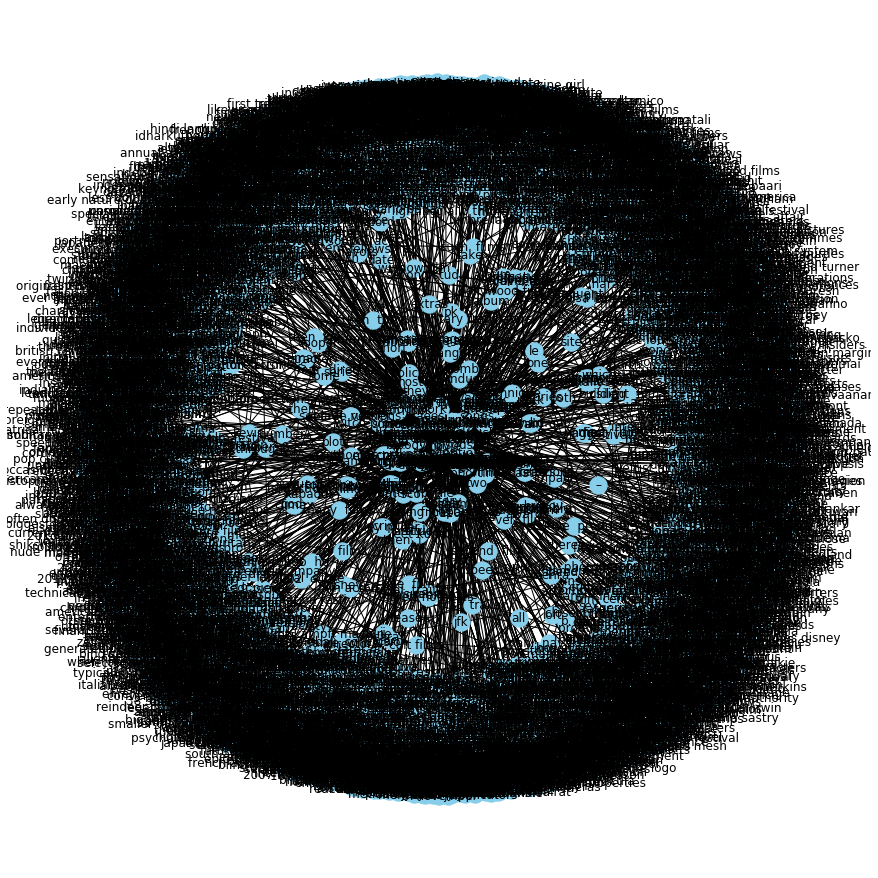

In [19]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Well, this is not exactly what we were hoping for (still looks quite a sight though!).

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. Let’s start with the relation “composed by”:

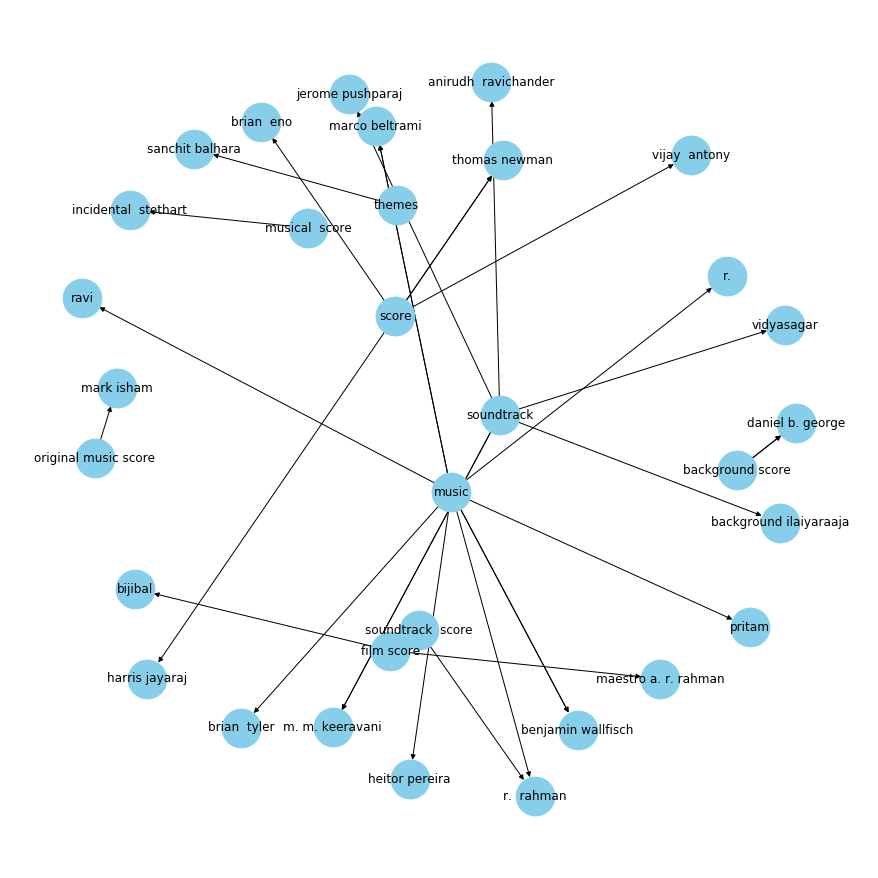

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s a much cleaner graph.
Let’s check out a few more relations.

Since writing is an important role in any movie, I would like to visualize the graph for the “written by” relation:

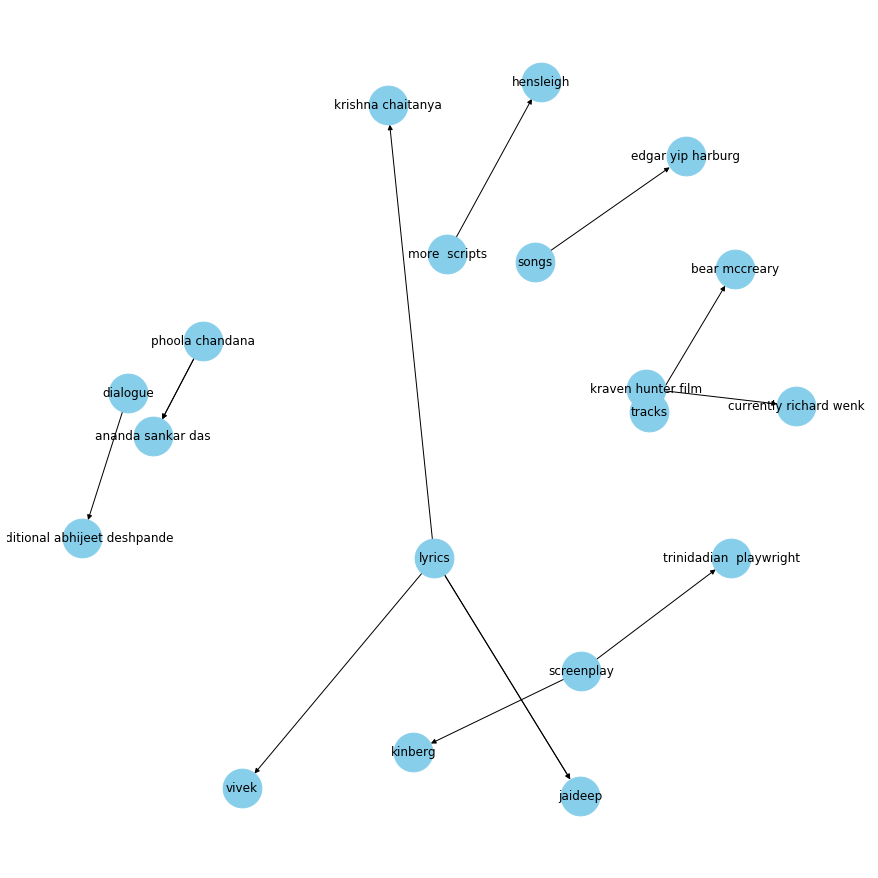

In [21]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Awesome! This knowledge graph is giving us some extraordinary information. Guys like Vivek, Krishna Chaitanya, and Jaideep are all famous lyricists and this graph beautifully captures this relationship.

Let’s see the knowledge graph of another important predicate, i.e., the “released in”:

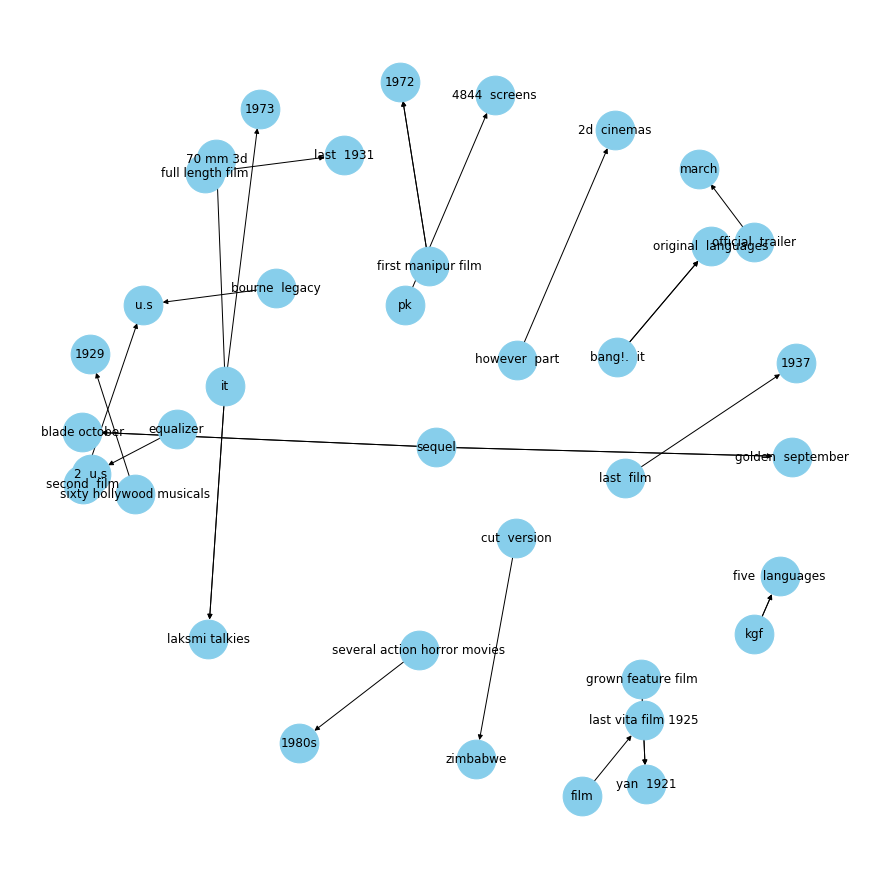

In [22]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

I can see quite a few interesting information in this graph. For example, look at this relationship – “several action horror movies released in the 1980s” and “pk released on 4844 screens”. These are facts and it shows us that we can mine such facts from just text. That’s quite amazing!
Thank You!!!